# Shapley value of features

Shapley value is a game theory tool allowing one to determine how much an agent contributes to a payoff game. It can be applied in machine learning to interpret each feature importance.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data gathering
df = pd.read_csv('feature_selection_result.csv', dtype=str)
df['Sensitivity'] = array(df['Sensitivity']).astype(float)
df['Specificity'] = array(df['Specificity']).astype(float)
df['MCC']         = array(df['MCC']).astype(float)
df['AUC']         = array(df['AUC']).astype(float)
df.head()

,Features,Sensitivity,Specificity,MCC,AUC
0,000000000000,0.453321,0.000000,0.000000,0.067767
1,000000000001,0.617647,0.587786,0.166876,0.289793
2,000000000010,0.554054,0.626374,0.180214,0.366895
3,000000000011,0.574468,0.704225,0.277120,0.464711
4,000000000100,0.623188,0.666667,0.287137,0.429324


In [4]:
lookup_results = {}
for ftr, sen, spe, mcc, auc in array(df):
    lookup_results[ftr] = [sen, spe, mcc, auc]

In [5]:
# Factorial function
def fact(n):
    if n not in fact.memoize:
        fact.memoize[n] = fact(n - 1)*n
    return fact.memoize[n]
fact.memoize = {0: 1}

In [26]:
# binary(n) converts n into a binary string
# useful to enumerate feature combinations
def binary_rec(n):
    if n not in binary_rec.memoize:
        binary_rec.memoize[n] = binary_rec(n // 2) + str(n % 2)
    return binary_rec.memoize[n]
binary_rec.memoize = {0: '0', 1: '1'}

def binary(n, l):
    if (n, l) not in binary.memoize:        
        b = binary_rec(n)
        binary.memoize[(n, l)] = '0'*(l - len(b)) + b
    return binary.memoize[(n, l)]
binary.memoize = {}

def binary_set(n):
    if n not in binary_set_memoize:
        binary_set_memoize[n] = [
            binary(i, n) for i in range(2**n)
        ]
    return binary_set_memoize[n]
binary_set_memoize = {}

def weight(bin_str):
    if bin_str not in weight_memoize:
        weight_memoize[bin_str] = sum(list(map(int, bin_str)))
    return weight_memoize[bin_str]
weight_memoize = {}

In [132]:
def get_joint(values, i, j, evaluation):
    assert i != j, "i and j must be different."
    value = 0
    for bin_str in binary_set(10):
        if i > j: i, j = j, i;  
        bin_str_in, bin_str_out = (
            bin_str[:i] + '1' + bin_str[i:j-1] + '1' + bin_str[j-1:],
            bin_str[:i] + '0' + bin_str[i:j-1] + '0' + bin_str[j-1:]
        )
        nu = values[bin_str_in][evaluation] - values[bin_str_out][evaluation]
        S = weight(bin_str)
        value += fact(S)*fact(10 - S)*nu
    return value/fact(11)

def get_marginal(values, i, j, evaluation):
    """ i: in, j: out """
    assert i != j, "i and j must be different."
    value = 0
    for bin_str in binary_set(10):
        a, b = min(i, j), max(i, j)
        bin_str_in, bin_str_out = (
            bin_str[:a] + 'a' + bin_str[a:b-1] + 'b' + bin_str[b-1:],
            bin_str[:a] + '0' + bin_str[a:b-1] + '0' + bin_str[b-1:]
        )
        if i == a:
            bin_str_in = bin_str_in.replace('a', '1').replace('b', '0')
        else:
            bin_str_in = bin_str_in.replace('a', '0').replace('b', '1')
        nu = values[bin_str_in][evaluation] - values[bin_str_out][evaluation]
        S = weight(bin_str)
        value += fact(S)*fact(10 - S)*nu
    return value/fact(11)          

In [133]:
def get_interaction(values, i, j, evaluation):
    return (
        get_joint(values, i, j, evaluation) - 
        get_marginal(values, i, j, evaluation) -
        get_marginal(values, j, i, evaluation)
    )

In [149]:
def get_shapley(values, i, evaluation):
    value = 0
    for bin_str in binary_set(11):
        bin_str_in, bin_str_out = (
            bin_str[:i] + '1' + bin_str[i:],
            bin_str[:i] + '0' + bin_str[i:]
        )
        nu = values[bin_str_in][evaluation] - values[bin_str_out][evaluation]
        S = weight(bin_str)
        value += fact(S)*fact(11 - S)*nu
    return value/fact(12)

In [150]:
results = array([
    [
        get_interaction(lookup_results, i, j, 2) if i != j else get_shapley(lookup_results, i, 2) 
        for j in range(12)
    ]
    for i in range(12)
])

In [159]:
def get_maxij(values, i, j, evaluation):
    return max(
        values[
            bin_str[:min(i, j)] + 
            '1' +
            bin_str[min(i, j):max(i, j)-1] +
            '1' +
            bin_str[max(i, j)-1:]
        ][evaluation]
        for bin_str in binary_set(10)
    )

def get_maxi(values, i, evaluation):
    return max(
        values[
            bin_str[:i] +
            '1' +
            bin_str[i:]
        ][evaluation]
        for bin_str in binary_set(11)
    )

In [161]:
results_max = array([
    [
        get_maxij(lookup_results, i, j, 2) if i != j else get_maxi(lookup_results, i, 2)
        for j in range(12)
    ]
    for i in range(12)
])

In [191]:
interactions = list(reversed(sorted(
    ((labels[i] +'/' + labels[j], results[i, j]) for i in range(12) for j in range(12) if i < j),
    key=lambda t: t[1]
)))
worst_interactions = interactions[-5:]
best_interactions = interactions[:5]

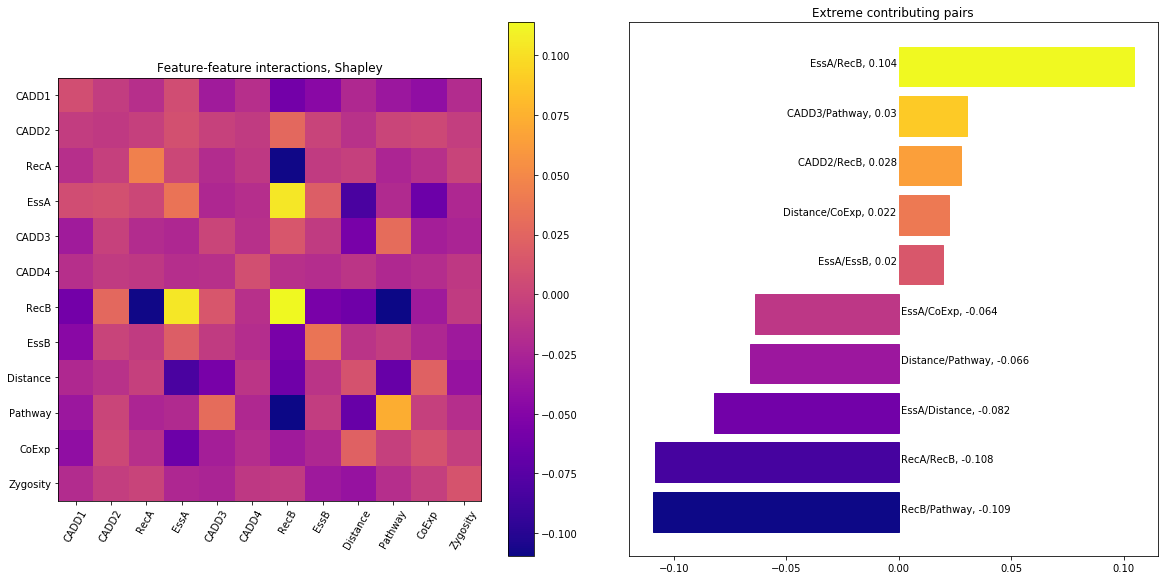

In [236]:
labels = [
    'CADD1', 'CADD2', 'RecA', 'EssA',
    'CADD3', 'CADD4', 'RecB', 'EssB',
    'Distance', 'Pathway', 'CoExp', 'Zygosity'
]
locs = arange(12)

fig, ax = subplots(1, 2, figsize=(16, 8))
tight_layout()

subplot(1,2,1)

img = imshow(results, cmap='plasma')
fig.colorbar(img, cmap='plasma')

xticks(locs, labels, rotation=60)
yticks(locs, labels)

title('Feature-feature interactions, Shapley')

subplot(1,2,2)

locs = arange(10)
interactions = list(reversed(best_interactions + worst_interactions))
bars = barh(locs, [x for _, x in interactions])

for i, attrs in enumerate(interactions):
    label, value = attrs
    text(
        -0.001 if i >= 5 else 0.001, 
        i, 
        label + ', ' + str(round(value*1000)/1000), 
        horizontalalignment='right' if i >= 5 else 'left'
    )
    
for bar, color in zip(bars, cm.plasma( linspace(0, 1, 10) )):
    bar.set_color(color)

yticks([], [])

title('Extreme contributing pairs')

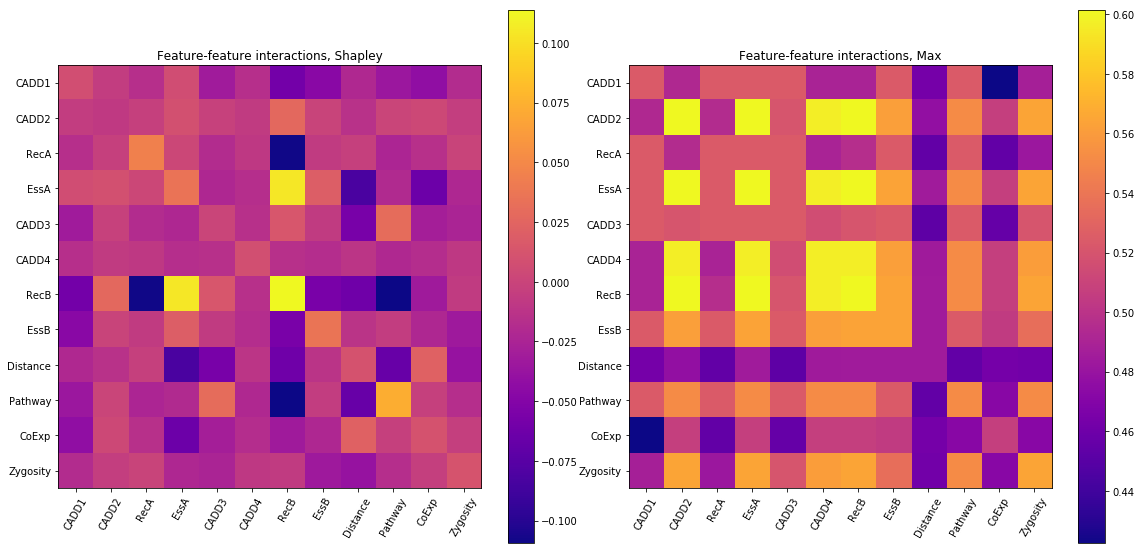

In [238]:
labels = [
    'CADD1', 'CADD2', 'RecA', 'EssA',
    'CADD3', 'CADD4', 'RecB', 'EssB',
    'Distance', 'Pathway', 'CoExp', 'Zygosity'
]
locs = arange(12)

fig, ax = subplots(1, 2, figsize=(16, 8))
tight_layout()

subplot(1,2,1)

img = imshow(results, cmap='plasma')
fig.colorbar(img, cmap='plasma')

xticks(locs, labels, rotation=60)
yticks(locs, labels)

title('Feature-feature interactions, Shapley')

subplot(1,2,2)

img = imshow(results_max, cmap='plasma')
fig.colorbar(img, cmap='plasma')

xticks(locs, labels, rotation=60)
yticks(locs, labels)

title('Feature-feature interactions, Max')